In [1]:
# Nature style
import matplotlib.pyplot as plt

fontsize = 7
small_fontsize = 7
capsize = 1.5
plt.rcParams.update({
    # Figure size and DPI
    'figure.dpi': 300, # High DPI for initial saving
    'savefig.dpi': 300, # High DPI for output file
    'savefig.bbox': 'tight', # Removes excess white space around figure
    'savefig.transparent': True, # Make the background transparent
    
    # Font settings
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica'], # Use Helvetica or Arial
    'pdf.fonttype': 42,
    # size: 5-7 
    'font.size': fontsize, # Base size. Axes labels will be this size.
    'axes.titlesize': fontsize, # Size of the axes title
    'axes.labelsize': fontsize, # Size of the x and y labels
    'xtick.labelsize': fontsize, # Size of the x-tick labels
    'ytick.labelsize': fontsize, # Size of the y-tick labels
    'legend.fontsize': fontsize, # Size of the legend text
    
    # Line settings
    'lines.linewidth': .5,
    'lines.markersize': 2,
    
    # Axes settings
    'axes.linewidth': 0.5, # Width of the axes border
    'xtick.major.width': 0.5, # Width of the x-tick lines
    'ytick.major.width': 0.5, # Width of the y-tick lines
    'xtick.major.size': 3, # Length of the x-ticks
    'ytick.major.size': 3, # Length of the y-ticks
    
    # Other settings
    'legend.frameon': False, # Remove the box around the legend
    'legend.handlelength': 1.5, # Length of the legend lines
})

# Define the WIDTH of your figure in inches (Single column: 89 mm, double column: 183 mm, max height: 170 mm)
width_in_inches = 85/25.4 # 85 mm
height_in_inches = 85/25.4 # 85 mm
figsize=(width_in_inches, height_in_inches)


In [2]:
import pandas as pd

df_all = pd.read_csv('dat/all_acc.txt', sep='\t')
df_all['error'] = 100 - df_all['acc'] * 100

# Group by continents and method, calculate mean, std, and count
df_grouped = df_all.groupby(['continents', 'ref'], as_index=False).agg(
    error_count=('error', 'count'),
    error_mean=('error', 'mean'),
    error_std=('error', 'std'),
    error_se=('error', 'sem'),
    # error_ci=('error', 'ci'),
)
print(df_grouped)

# Specify method order
ref_order = ['SNPBag', 'REF', 'noREF']

# Specify colors for each method
palette = {
    'SNPBag': 'red',
    'REF': 'deepskyblue',
    'noREF': 'royalblue',
}


   continents     ref  error_count  error_mean  error_std  error_se
0         AFR     REF           24    3.899423   2.346355  0.478948
1         AFR  SNPBag            8    5.011311   2.558786  0.904667
2         AFR   noREF           16   10.574995   1.155825  0.288956
3         AMR     REF           12    1.404383   0.560762  0.161878
4         AMR  SNPBag            4    1.478942   0.547934  0.273967
5         AMR   noREF            8    3.590091   0.826429  0.292187
6         CSA     REF            6    2.340286   0.077826  0.031772
7         CSA  SNPBag            2    2.432102   0.037646  0.026619
8         CSA   noREF            4    6.205638   0.481502  0.240751
9         EAS     REF           12    2.276234   0.885415  0.255597
10        EAS  SNPBag            4    2.362707   0.982327  0.491164
11        EAS   noREF            8    5.045149   0.787604  0.278460
12        EUR     REF            6    0.987488   0.083593  0.034127
13        EUR  SNPBag            2    1.303163  

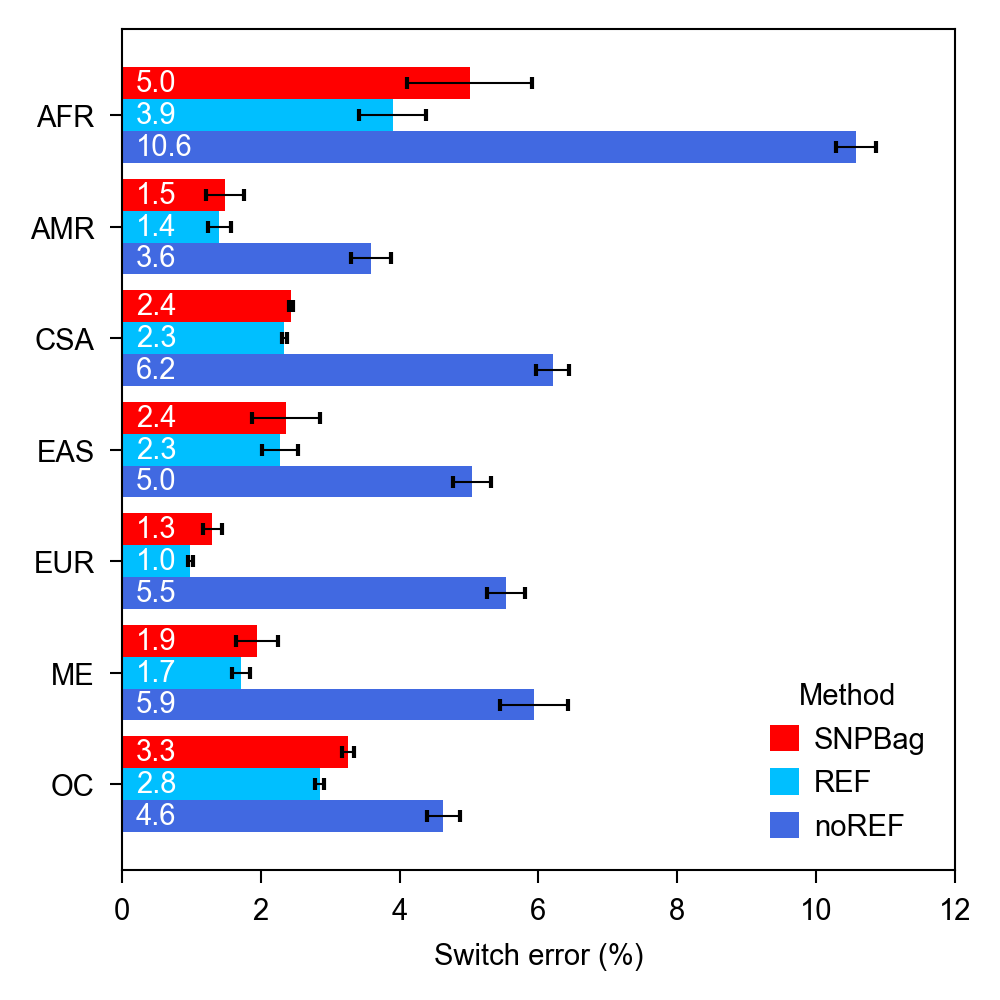

In [3]:
# Horizontal barplot of switch error by method and continent with error bars
# Continents and methods appear from top to bottom

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Ensure the columns and variables exist and are named correctly
# We'll plot 'error_mean' with 'error_se' as error bars, grouped by continent and method

# Sort dataframe for consistent plotting
# Reverse continents and methods for top-to-bottom order
continents = list(df_grouped['continents'].unique())[::-1]  # reverse for top-to-bottom
methods = ref_order[::-1]  # reverse for top-to-bottom
n_continents = len(continents)
n_methods = len(methods)

df_grouped['ref'] = pd.Categorical(df_grouped['ref'], categories=ref_order, ordered=True)
df_grouped = df_grouped.sort_values(['continents', 'ref'])

# Set up bar positions
bar_height = 0.2
group_height = bar_height * n_methods + 0.1
y_pos = []
y_labels = []
for i, continent in enumerate(continents):
    for j, method in enumerate(methods):
        y_pos.append(i * group_height + j * bar_height)
        y_labels.append(f"{continent} - {method}")

# Get plotting values in the same order (continents and methods reversed)
plot_df = []
for continent in continents:
    for method in methods:
        row = df_grouped[(df_grouped['continents'] == continent) & (df_grouped['ref'] == method)]
        if not row.empty:
            plot_df.append(row.iloc[0])
        else:
            # If missing, fill with NaN
            plot_df.append(pd.Series({'error_mean': np.nan, 'error_se': np.nan, 'continents': continent, 'ref': method}))

plot_df = pd.DataFrame(plot_df)

# Colors for each method (need to match reversed order)
bar_colors = [palette.get(method, 'gray') for method in plot_df['ref']]

plt.figure(figsize=figsize)

bars = plt.barh(
    y=y_pos,
    width=plot_df['error_mean'],
    xerr=plot_df['error_se'],
    capsize=capsize,
    edgecolor=None,  # Remove the outline of the bars
    color=bar_colors,
    height=bar_height,
    linewidth=0,     # Remove the outline of the bars
)

# Add text to each bar
for bar, mean, se in zip(bars, plot_df['error_mean'], plot_df['error_se']):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(
        0.2,
        y,
        f"{mean:.1f}",
        va='center',
        ha='left',
        fontsize=small_fontsize,
        color='white'
    )

# Set y-ticks and labels (continents from top to bottom)
plt.yticks(
    [i * group_height + (n_methods-1)*bar_height/2 for i in range(n_continents)],
    continents
)
plt.xlabel("Switch error (%)")
plt.xlim(0, max(12, np.nanmax(plot_df['error_mean'] + plot_df['error_se']) + 1))

# Add legend for methods (from top to bottom)
# To make the legend appear from top to bottom, reverse the handles and labels order
legend_handles = [
    Patch(facecolor=palette[method], edgecolor=None, label=method)
    for method in methods
]
# By default, matplotlib puts the first handle at the top, so we reverse to match top-to-bottom
legend_handles = legend_handles[::-1]
plt.legend(handles=legend_handles, title="Method", loc='lower right', frameon=False, fontsize=fontsize, title_fontsize=fontsize, handlelength=1, handleheight=1, handletextpad=0.5, borderpad=0.5)

plt.tight_layout()
plt.savefig('switch_error_continents_barplot.pdf')
plt.show()
plt.close()